## KNN Model for predicting postseason wins

In [2]:
import pandas as pd
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars.selectors as cs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

df = pl.read_csv('../input_data/model_data.csv')
print(df.shape)
display(df.head())

(748, 21)


G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,POSTSEASON_WINS
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1,5
40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1,5
40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,3,5
38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,3,5
39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,1,5


## Split the data to test and train for KNN validation

In [ ]:
x = df.select(pl.all().exclude('POSTSEASON_WINS'))
y = df.select('POSTSEASON_WINS')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=84305)

## feature scaling as we have many different values - important to do after the test train split
scaler = StandardScaler()

## use fit transform for training to learn the transformations and just transform for the rest
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Standard framework for KNN model. Starting somewhere to see what we get
* Using the default values we do worse than if we just guessed 0 for every team
* Makes some sense as we have very few datapoints for 4,5,6 wins and a ton for 0
* Probably should have picked something different to predict as solving this might require some more manipulation such as resampling, creating new data
* Confusion matrix gives a better idea of what we are guessing and we can see our model basically never picks those higher win values

In [4]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
# Make predictions on the test set
y_pred = knn.predict(x_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

## accuracy of picking the most frequent
most_freq_value = y_test['POSTSEASON_WINS'].value_counts(sort = True, name = 'count')['count'][0]
total = len(y_test)
guess_most_freq_acc = most_freq_value / total
print('Just guess 0 accuracy', guess_most_freq_acc)

c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.5133333333333333
Just guess 0 accuracy 0.5466666666666666


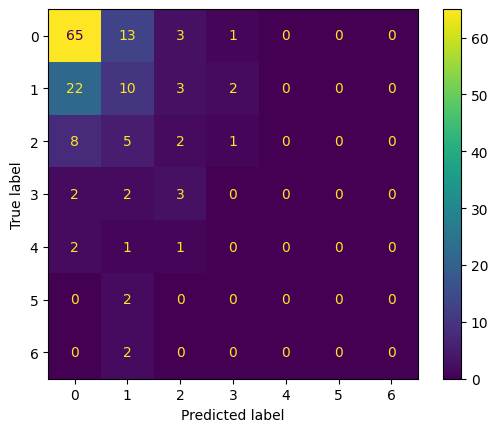

In [5]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=knn.classes_).plot()

## Next we can add features to optimize our results such as cross-validation to get a better insight into our accuracy and the elbow method to pick the optimal value of K

## We should also do principal component analysis because we have a lot of variables


https://www.kaggle.com/code/milanvaddoriya/knn-with-pca-and-elbow-method-for-beginners

In [6]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, x_train, y_train, cv = 10, scoring='accuracy')
scores

c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

array([0.5       , 0.51666667, 0.45      , 0.48333333, 0.45      ,
       0.48333333, 0.45      , 0.58333333, 0.54237288, 0.52542373])

In [22]:
from sklearn.decomposition import PCA

## we can set the value to .9 so we ensure we are explaining 90% of the variance
pca = PCA(.90)

x_scaled = scaler.fit_transform(x)
x_pca = pca.fit_transform(x_scaled)
print('We will be using this many components:', pca.n_components_)

We will be using this many components: 10


In [24]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y, test_size=0.2, random_state=84305)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_pca, y_train_pca)
# Make predictions on the test set
y_pred_pca = knn.predict(x_test_pca)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test_pca, y_pred_pca)
print('Accuracy:', accuracy)

Accuracy: 0.5466666666666666


c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.79      0.72        82
           1       0.29      0.27      0.28        37
           2       0.17      0.12      0.14        16
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2

    accuracy                           0.51       150
   macro avg       0.16      0.17      0.16       150
weighted avg       0.45      0.51      0.48       150



c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital